In [1]:
import numpy as np
import pandas as pd
import time

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk("input"):
    print(dirname)

input
input\evaluation
input\training


In [2]:
#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
data_path = Path('input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

In [3]:
#已解決的ID
solved_id=set()
solved_eva_id=set()

In [4]:
T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)

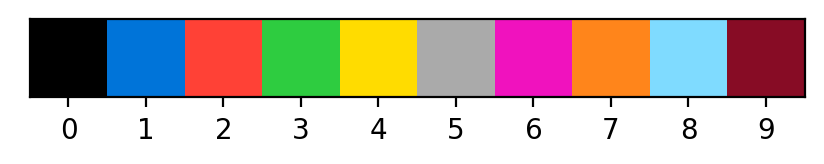

In [5]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

In [6]:

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

In [7]:
def Defensive_Copy(A): 
    if type(A)!=list:
        A=A.tolist()
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

In [8]:
def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

In [9]:
BACKGROUND=0
def _get_bound(img0):
    img=np.array(img0)
    h, w = img.shape
    x0 = w - 1
    x1 = 0
    y0 = h - 1
    y1 = 0
    for x in range(w):
        for y in range(h):
            if img[y, x] == BACKGROUND:
                continue
            x0 = min(x0, x)
            x1 = max(x1, x)
            y0 = min(y0, y)
            y1 = max(y1, y)
    return x0, x1, y0, y1
def get_bound_image(img0):
    x0,x1,y0,y1=_get_bound(img0)
    img=np.array(img0)
    return img[y0:y1+1,x0:x1+1].tolist()

In [10]:
def getObjectHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2 ** x for x in range(len(flat))])
    return np.sum(flat * mult)
#經測試沒有overflow問題
def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    return [x for x in splited if np.any(x)]
def checkColorMap(a0,b0):
    a=np.array(a0)
    b=np.array(b0)
    c = 1
    inp_hashes = sorted([getObjectHash(pm) for pm in groupByColor(a)])
    out_hashes = sorted([getObjectHash(pm) for pm in groupByColor(b)])
    c *= inp_hashes == out_hashes
    return bool(c)
def findColorMap(a,b):
    colormap = {}
    a1=np.array(a).flatten()
    b1=np.array(b).flatten()

    for col, idx in zip(*np.unique(a1,return_index=True)):
        if col in colormap.keys(): continue
        colormap[col] = b1[idx]
    return colormap

def mergedict(dict1):
    dict3={}
    for dict2 in dict1:
        for key in dict2.keys():
            if key not in dict3.keys():
                dict3[key]=dict2[key]
            elif dict3[key]!= dict2[key]:
                return False
    return dict3
def applyColorMap(pixmap, colormap):
    a1=np.array(pixmap)
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] not in colormap: #
                continue #
            a1[i][j]=colormap[pixmap[i][j]]
    return a1.tolist()

In [11]:
#array
def resize_o(a,r1,r2):
    try:
        
        return np.repeat(np.repeat(a, r1, axis=0), r2, axis=1)
    except:
        return a
    
def resize_c(a):
    c = np.count_nonzero(np.bincount(a.flatten(),minlength=10)[1:])
    return np.repeat(np.repeat(a, c, axis=0), c, axis=1)

def resize_2(a):
    return np.repeat(np.repeat(a, 2, axis=0), 2, axis=1)

def resize_3(a):
    return np.repeat(np.repeat(a, 2, axis=0), 2, axis=1)


In [12]:
resize_type=[resize_o,resize_c]

In [13]:
def Solve_resize(basic_task): 
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    same_ratio = True
    colormaps={}
    R_x = []
    R_y = []
    r1,r2=0,0
    for x, y in zip(Input, Output):
        if len(np.unique(x))==1 and np.unique(x)[0]==0:
            return -1
        n1 = len(x)
        n2 = len(y)
        k1 = len(x[0])
        k2 = len(y[0])
        if n2%n1 != 0 or k2%k1 != 0:
            same_ratio = False
            break
        else :
            R_y.append(n2//n1)
            R_x.append(k2//k1)
    if same_ratio and min(R_x) == max(R_x) and min(R_y) == max(R_y): 
        r1 = min(R_y)
        r2 = min(R_x)
    for x, y in zip(Input, Output):
        x_array=np.array(x)
        y_array=np.array(y)
        if r1==0 or r2==0:
            return -1
        pre_y=resize_o(x_array,r1,r2)
        if checkColorMap(pre_y,y_array)==False:
            return -1
        else:
            colormap=findColorMap(pre_y,y_array)
        if mergedict([colormaps,colormap])==False:
            return -1
        colormaps=mergedict([colormaps,colormap])
        pre_y_list=applyColorMap(pre_y,colormaps)
        if pre_y_list!=y:
            return -1
    
    Test_Case_array=np.array(Test_Case)
    return applyColorMap(resize_o(Test_Case_array,r1,r2),colormaps)
    
    

In [14]:
def Solve_resize_bound(basic_task): 
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    same_ratio = True
    R_x = []
    R_y = []
    colormaps={}
    r1,r2=0,0
    for x0, y in zip(Input, Output):
        if len(np.unique(x0))==1 and np.unique(x0)[0]==0:
            return -1
        
        x=get_bound_image(x0)
        n1 = len(x)
        n2 = len(y)
        k1 = len(x[0])
        k2 = len(y[0])
        if n2%n1 != 0 or k2%k1 != 0:
            same_ratio = False
            break
        else :
            R_y.append(n2//n1)
            R_x.append(k2//k1)
    if same_ratio and min(R_x) == max(R_x) and min(R_y) == max(R_y): 
        r1 = min(R_y)
        r2 = min(R_x)
    for x0, y in zip(Input, Output):
        x=get_bound_image(x0)
        x_array=np.array(x)
        y_array=np.array(y)
        if r1==0 or r2==0:
            return -1
        pre_y=resize_o(x_array,r1,r2)
        if checkColorMap(pre_y,y_array)==False:
            return -1
        else:
            colormap=findColorMap(pre_y,y_array)
        if mergedict([colormaps,colormap])==False:
            return -1
        colormaps=mergedict([colormaps,colormap])
        pre_y_list=applyColorMap(pre_y,colormaps)
        if pre_y_list!=y:
            return -1
    
    Test_Case_array=np.array(get_bound_image(Test_Case))
    return applyColorMap(resize_o(Test_Case_array,r1,r2),colormaps)

In [15]:
def Solve_resizec(basic_task): 
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    colormaps={}
    for x, y in zip(Input, Output):
        if len(np.unique(x))==1 and np.unique(x)[0]==0:
            return -1
        x_array=np.array(x)
        y_array=np.array(y)
        
    
        pre_y=resize_c(x_array)
        if pre_y.shape[0]>30 or pre_y.shape[1]>30:
            return -1
        
        if checkColorMap(pre_y,y_array)==False:
            return -1
        else:
            colormap=findColorMap(pre_y,y_array)
        if mergedict([colormaps,colormap])==False:
            return -1
        colormaps=mergedict([colormaps,colormap])
        pre_y_list=applyColorMap(pre_y,colormaps)
        
        if np.shape(pre_y)!=np.shape(y_array) or  pre_y_list!=y:
            return -1

    Test_Case_array=np.array(Test_Case)
    return applyColorMap(resize_c(Test_Case_array),colormaps)
        

In [16]:
def Solve_resizec_bound(basic_task): 
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    colormaps={}
    for x0, y in zip(Input, Output):
        if len(np.unique(x0))==1 and np.unique(x0)[0]==0:
            return -1
        x=get_bound_image(x0)
        x_array=np.array(x)
        y_array=np.array(y)
        
    
        pre_y=resize_c(x_array)
        if pre_y.shape[0]>30 or pre_y.shape[1]>30:
            return -1
        
       
        if checkColorMap(pre_y,y_array)==False:
            return -1
        else:
            colormap=findColorMap(pre_y,y_array)
        if mergedict([colormaps,colormap])==False:
            return -1
        colormaps=mergedict([colormaps,colormap])
        pre_y_list=applyColorMap(pre_y,colormaps)
        
        if np.shape(pre_y)!=np.shape(y_array) or  pre_y_list!=y:
            return -1

    Test_Case_array=np.array(get_bound_image(Test_Case))
    return applyColorMap(resize_c(Test_Case_array),colormaps)

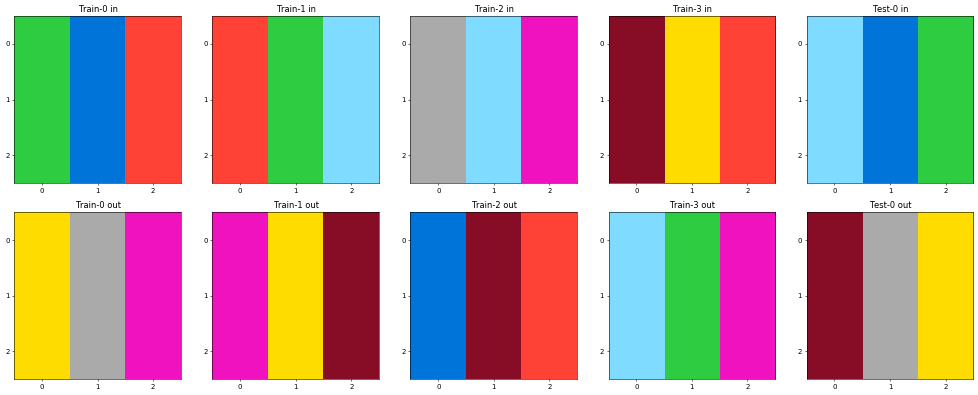

15


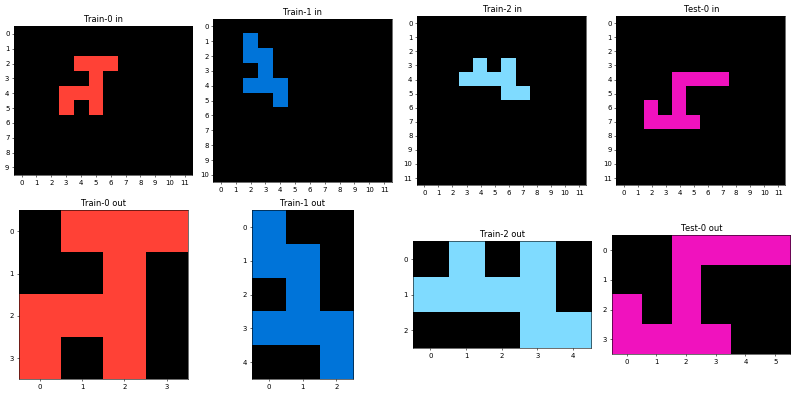

30


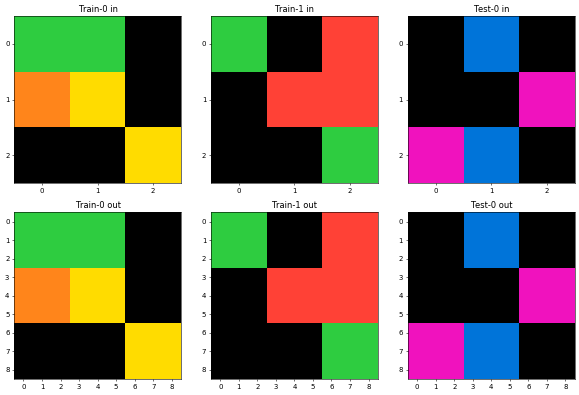

222


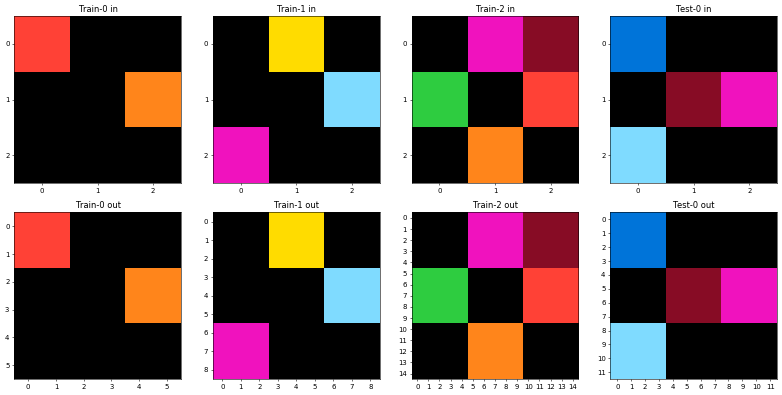

268


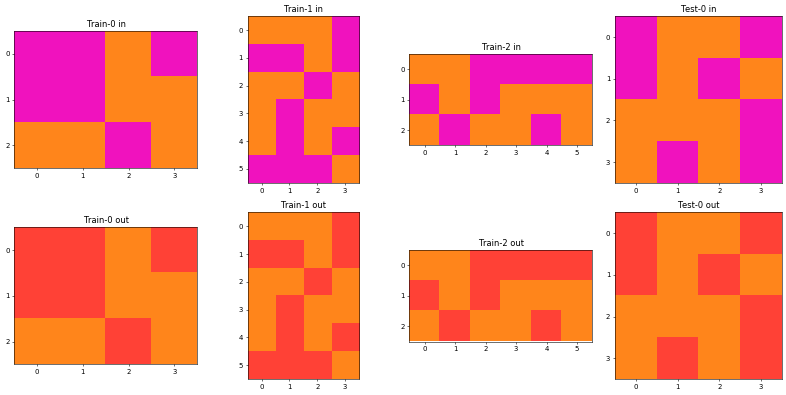

275


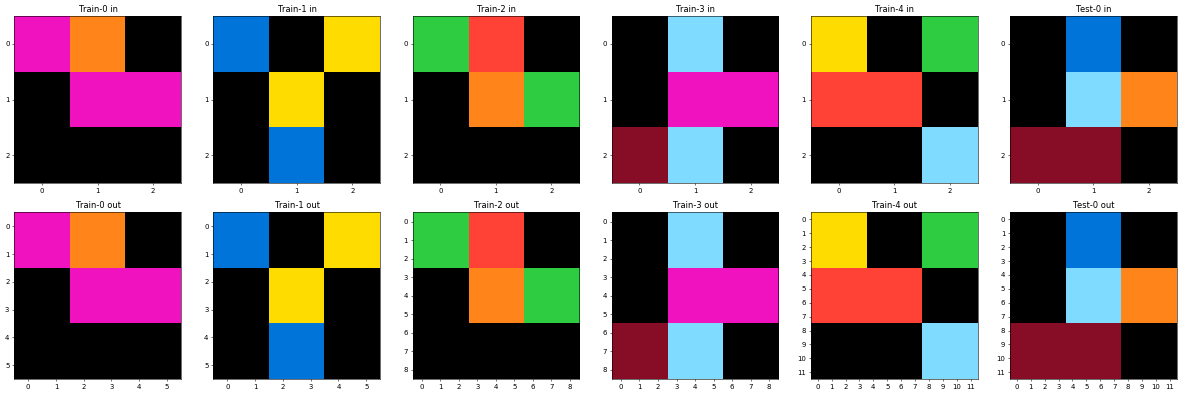

288


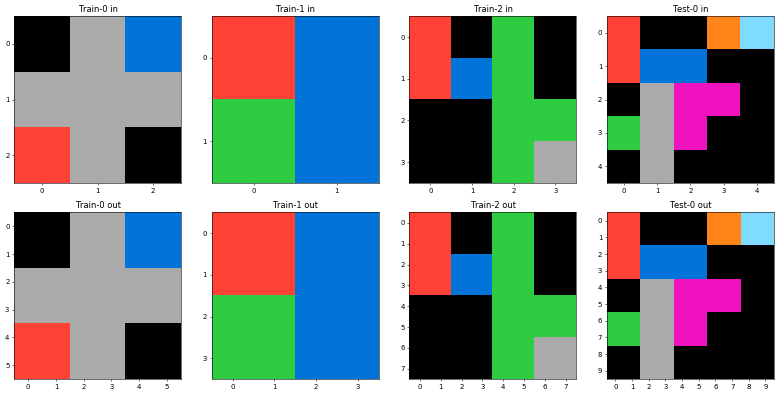

306


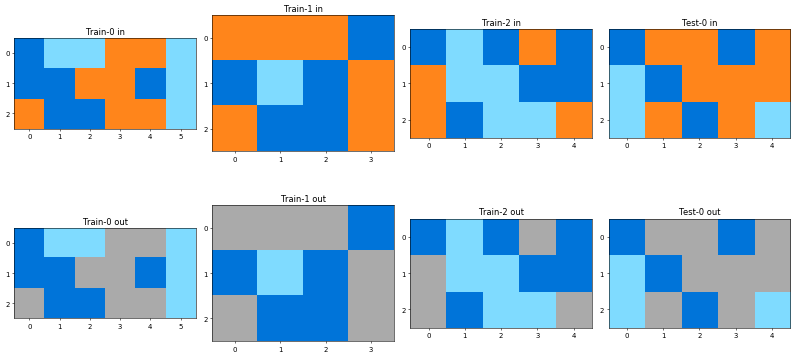

308


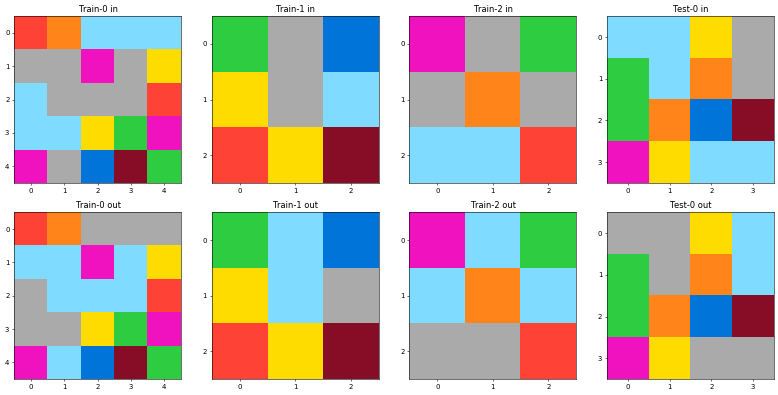

336


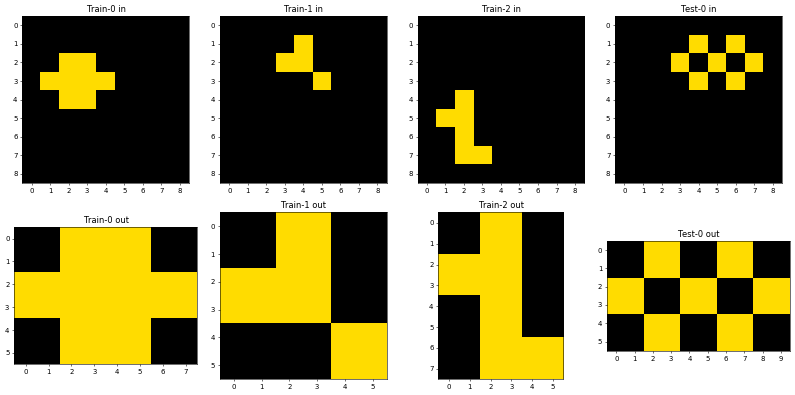

383


In [17]:
for i in range(400):
    task = Trains[i]
    basic_task = Create(task,0)
    a = Solve_resize(basic_task)
    b = Solve_resizec(basic_task)
    c = Solve_resize_bound(basic_task)
    d = Solve_resizec_bound(basic_task)
  
    if  a!=-1 or b != -1 or c!=-1 or d!=-1:
        plot_task(task)
        print(i)
        solved_id.add(i)

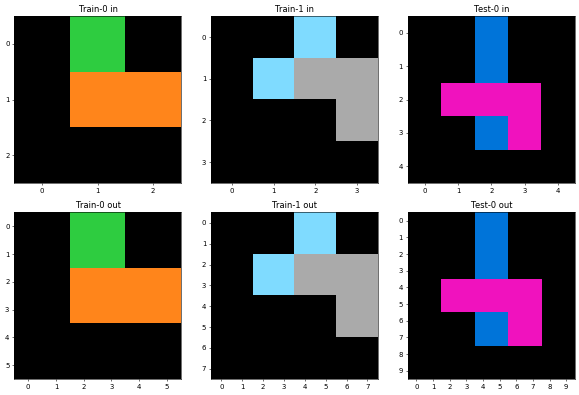

148


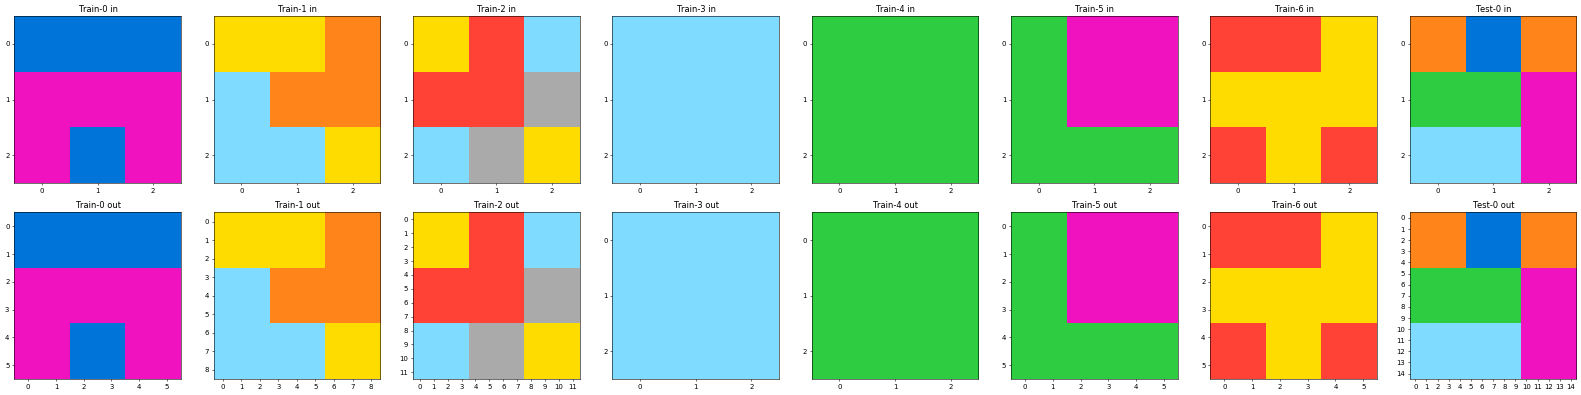

325


In [18]:
for i in range(400):
    task = Evals[i]
    basic_task = Create(task,0)
    a = Solve_resize(basic_task)
    b = Solve_resizec(basic_task)
    c = Solve_resize_bound(basic_task)
    d = Solve_resizec_bound(basic_task)
  
    if  a!=-1 or b != -1 or c!=-1 or d!=-1:
        plot_task(task)
        print(i)
        solved_eva_id.add(i)

In [19]:
list(solved_id)

[288, 268, 15, 336, 306, 275, 308, 30, 222, 383]

In [20]:
list(solved_eva_id)

[148, 325]